#### PreQC step before running on Geneious
#### Sample ID check (Check length of the Sample ID such as AMD_ID) 
#### Sample count check (Count number of samples - For example how many samples did Stefano ran?)
#### Below block is the code for running the preQC

Malaria has been a major illness in Africa. The drug resistance of malaria is making it more difficult to treat the patients with Malaria. To overcome the drug resistance CDC is developing a surveillance protocol for tracking drug ressitance of malarial genes. As part of the protocol and basic step we analyze Plasmodium Falciparum genes gained for patients. This ReadME is for other users to understand the work I've done which analyzes genes and reports findings. 

## ReadMe for Geneious workflow and scripts for reports for lab and EPI

####  1. Importing raw fastq files
        First import the raw fastq files to geneious. Then, select whole samples then click sequence on top menu. After clicking sequence, click set paired reads.
        For the option select paired reads and delete unpaired ones.
####  2. Geneious Workflow
    Geneious Workflow contains mainly four steps for processing raw sequences to variants and coverage. You select a samples then go to workflows and run the SNP_Coverage_Analysis.geneiousWorkflow. Then, it automatically runs all the below steps from a -> d. 
    
###### a. Trimming (Discard unnecessary reads that would cause noise to the data)
    Geneious uses BBduk for trimming raw sequences. The settings are
    1. Trim Adapters: All Truseq, Nextera and PhilX adapters 
    ✓ Trim Right End
    ✓ Kmer Length 27 
    ✓ Maximum Substitutions 1 
    ✓ Maximum Substitutions + INDELs: 0,
    2. Trim Low quality: 
    ✓Both Ends 
    ✓Minimum Quality 35
    3. Trim Adapters based on paired read overhangs: Minimum Overlap: 24
    4. Discard Short Reads: Minimum Length: 150 bp

###### b. Map to Reference (To observe differences in genetic structure from reference)
    The workflow uses Map to reference for algining reads to the reference
    1. Dissolve contigs and re-assemble: reference sequecne is updated_MaRS_refs_ET (6sequences), 
    Assemble each sequence list separately
    2. Mapper: 
    ✓ Bowtie2 
    ✓ alginment Type: End to End 
    ✓ Use Preset: High Sensitivity/Medium
    3. Do not trim (discrad trim annotations)
    4. Save contigs
    
###### c. Find Variations/SNPs (To find the unique genetic structure from the samples)
    1. Find Variants: Minimum Variant Frequency: 0.05
    2. Analtze effect of variants on translations : Default Genetic Code, Standard
    3. Advanced: Use separate annotations for each variant at a position
     ✓ Record names of all contributing sequences of each variant
     ✓ Only find variations in annotation types = TrackerSNP
     ✓ Also find varations within 0bases of those types
     ✓ CDS properties to Copy: gene, product, protein_id, locus, tag, note.
    
###### d. Find coverage (To see if there are WildTypes we are interested )
    1. Only Find in: Annotations in reference sequence of type: TrackerSNP, Create coverage annotations on reference sequence
    2. High Coverage: Find regions with coverage above, number of sequences: 0
    
###### e. Selecting workflow outputs (contigs )
    1. After the workflow is done contig documents will be generated in the same folder with AMD_ID and gene information
    2. To select the contigs you click on modified 
    * If you can't see modified header scroll to the right 
    3. Then select the files that are generated later with AMD_ID and gene information in the document title
    
###### f. Export findings to a csv raw output (To process more data )
    1. Select all the documents with coverage and variant information
    * Select in as mentioned in step e
    2. Select all the columns
    3. Select all the types
    4. Export table 
    * Export as Annotations.csv


#### 2. Python scripts for Geneious raw input
###### a. Read Annotations.csv file and process
    1. Python script has with open function to open file and read each lines from the file
    2. Each jupyter note script will process Geneious raw output for different purposes.

###### b. File1: DF_Analysis1.ipynb/DF_Analysis1_EP.ipynb
    1. There are two versions one for lab and another one for EPI
    2. This version is written using pandas dataframe.
    3. The output gives information such as SITE,Sequence Name,G_Annotation,SNP,Mutation,WildType,VAF



    
    
  



## Geneious analysis for individual samples from raw Geneious output, "Annotation.csv" 

 ### Required packages
 - No specific package required 
 
 ### Inputs
 - Geneious SNP analysis of _k13_, _crt_, _mdr1_, _dhfr_, _dhps_, and _cytb_
 - Documentation on Geneious analysis can be found: Readme.md
 - Geneious outputs were modified to GuineaAnalysis_Individual.csv from "Annotation.csv"
 
 
 ### Data structure 
 - [Long-form](https://seaborn.pydata.org/tutorial/data_structure.html#long-form-vs-wide-form-data) 
     - Each variable is a column 

         - "Sample" = *AMD ID*, including associated meta-data for each sample
             - AMD ID and bit code key is found under MS Teams > Domestic > Files > Sample Naming > Sample_naming_key.pptx  

             - Key: **Year Country State/Site DayofTreatment Treatment SampleID Genus SampleType GeneMarker-8bitcode SampleSeqCount**

                 - Example:
                     - Individual sequenced sample ID: 17GNDo00F0001PfF1290 = 2017 Guinea Dorota Day0 AS+AQ 0001 P.falciparum FilterBloodSpot k13-crt-mdr-dhfr-dhps-cytB-cpmp-pfs47 

                     - Pooled sequenced sample ID: 17GNDoxxx001P10F1290 = 2017 Guinea Dorota **xx x** 001 **Pooled SamplesInPool** P.falciparum FilterBloodSpot k13-crt-mdr-dhfr-dhps-cytB-cpmp-pfs47 

                         - NOTE: If information is not availble (na) **x** is used. For pooled samples, DayofTreatment and Treatment is na since its a pool of multiple samples with that info. 
                         - NOTE: For pooled samples, **Genus** is replaced with **Pooled** and **SampleType** with **SamplesInPool** to indicated this as a pooled sequenced sample and sample count in each pool. 
         <p>&nbsp;</p>
         - "Year" = the year the study was conducted 
         - "Site" = the state or province 
         - "Day_of_treatment" = describes the day of treatment provided to the patient 
         - "Gene" = drug resistant gene(s) 
         - "G_annotation" = full SNP annotation in the following format: WildTypeAA-CodonPosition-MutantAA 
         - "Coverage" = the number of reads covering the SNP 
         - "VAF" = variant allele frequency calculated by AA divided by total reads in loci 
         - "SNP" = single nucleotide polymorphism in WildTypeAA or MutantAA annotation format 
         - "Type" = describes if it is a wild type or mutant SNP 

     - Each observation is a row for each sample ID (patient ID) 

In [61]:
import pandas as pd ## Import Pandas library for processing dataframe as pd
import numpy as np ## Import Numy for processing matrix as np
Geneious_DF=pd.read_csv("Annotations.csv") ##Import raw Geneious output for variant analysis
Geneious_DF_N1=Geneious_DF[(Geneious_DF['Type']=='Polymorphism') & (Geneious_DF['Amino Acid Change'].notnull())] ##If the type column contains polymorphism and Amino Acid Change column is not empty then create a dataframe satisfying those conditions

Geneious_DF_N2=Geneious_DF[Geneious_DF['Type']=='Coverage - High'] ##If the Coverage - High is in the type column as value then select dataframe for those column values

Geneious_DF_N1["TrackerSNP"]=Geneious_DF_N1["Amino Acid Change"].astype(str).str[0]+Geneious_DF_N1["CDS Codon Number"].astype(int).astype(str)+Geneious_DF_N1["Amino Acid Change"].astype(str).str[-1] ##Create a TrackerSNP Column which has both amino acid before the change and after the change

Combine_Variant_Wildtpye = [Geneious_DF_N1, Geneious_DF_N2] ##Produce a complete dataframe which contains both variants and wildtypes
Combation_Vi_Wi = pd.concat(Combine_Variant_Wildtpye) ##Concatenate the dataframes for variants and wildtypes
Combination_filtered=Combation_Vi_Wi.drop_duplicates(subset =["Document Name", "TrackerSNP"] )  ##Drop duplicates meaning if the values are already in variants then drop it from the wildtypes
##The dataframe contains information, "Sample,Pooled,Year,SITE,TreatmentDay,GENE,G_annotation,COVERAGE,VAF,VF,SNP,TYPE\n")

def site(row): ##Set up a function for assignging site based on the values in the document name column. This will change with each study please update the sites. 
    if row['Document Name'][4:6]=="Be":
        return 'Benguela'
    elif row['Document Name'][4:6]=="LS":
        return 'Lunda Sul'
    elif row['Document Name'][4:6]=="Za":
        return 'Zaire'
    
def TreatmentDay(row): ##Set up a function for assigning TreatmentDay based on the values in the document name column
    if row['Document Name'][6:8]=="00":
        return '0'
    elif row['Document Name'][6:8]=="1A": ##To do: confirm this with Stefano whether it was a naming issue.
        return '1'
    elif row['Document Name'][6:8]!="00" and row['Document Name'][6:8]!="1A":
        return row['Document Name'][6:8]
    
def Pooled(row): ##Set up a function for Pooled based on the values in the document name column
    if row['Document Name'][8:10]=="xp":
        return 'pooled'
    elif row['Document Name'][8:10]!="xp":
        return 'individual'

def year(row):  ##Set up a function for Year  based on the values in the document name column
    return row['Document Name'][0:2]

def type(row):  ##Set up a TYPE column based on given value in the Type whether it is mutation or wildtype
    if row['Type'] =='Polymorphism':
        return "mutation"
    if row['Type'] =='Coverage - High':
        return "wildtype"
    
def SNP(row):  ##Set up a SNP column to give pre or post amino acid changes based on mutation or wildtype
    if row['Type'] =='Polymorphism':
        return row['TrackerSNP'][1::]
    if row['Type'] =='Coverage - High':
        return row['TrackerSNP'][0:-1]
    
    


    
Combination_filtered["SITE"]=Combination_filtered.apply(site, axis=1) ##Apply the functions defined previously
Combination_filtered["TreatmentDay"]=Combination_filtered.apply(TreatmentDay, axis=1)
Combination_filtered["Pooled"]=Combination_filtered.apply(Pooled, axis=1)
Combination_filtered["Year"]=Combination_filtered.apply(year, axis=1)
Combination_filtered["TYPE"]=Combination_filtered.apply(type, axis=1)
Combination_filtered["SNP"]=Combination_filtered.apply(SNP, axis=1)



Combination_report1=Combination_filtered[Combination_filtered['Type']=='Polymorphism'] ##Select columns with mutations
Combination_report2=Combination_filtered[Combination_filtered['Type']=='Coverage - High'] ##Select columns with wildtypes
final_report1=Combination_report1[["Document Name","Sequence Name","SITE","TreatmentDay","Pooled","Year","Coverage","Variant Frequency","Variant Raw Frequency","TrackerSNP","TYPE","SNP"]] ##Assign sample information to samples with mutation
final_report2=Combination_report2[["Document Name","Sequence Name","SITE","TreatmentDay","Pooled","Year","Average Coverage","Variant Frequency","Variant Raw Frequency","TrackerSNP","TYPE","SNP"]] ##Assign sample information to samples with wildtypes
final_report2_re=final_report2.rename(columns={'Average Coverage': 'Coverage'}) ##Change the name of average coverage to coverage for samples with wildtypes
final_combine=[final_report1, final_report2_re] ##Combine the information from wildtypes and mutations into one dataframe
final_combine_2=pd.concat(final_combine) ##concatenate
final_combine_2.to_csv("AN19_individual_LAB.csv", sep=',', index=False) ##Create a file with the dataframe for testing purpose

df_voi=pd.read_csv("voinew3.csv")
df_voi["VOI"]=df_voi["RefAA"]+df_voi["AAPos"].astype(str)+df_voi["AltAA"]
voi_list=df_voi["VOI"].tolist()

#final_combine_2['Sequence Name'].replace({'DHPS_437Corrected ': 'DHPS'}, inplace=True)
#df["column1"].replace({"a": "x", "b": "y"}, inplace=True)

final_combine_3=final_combine_2[final_combine_2["Pooled"]=="individual"]
final_combine_3=final_combine_3[final_combine_3.TrackerSNP.isin(voi_list)]
final_combine_3=final_combine_3.rename(columns={'Document Name': 'Sample'})
final_combine_3=final_combine_3.rename(columns={'Sequence Name': 'GENE'})
final_combine_3=final_combine_3.rename(columns={'TrackerSNP': 'G_annotation'})
final_combine_3=final_combine_3.rename(columns={'Variant Frequency': 'VAF'})
final_combine_3=final_combine_3.rename(columns={'Variant Raw Frequency': 'VF'})
final_combine_3=final_combine_3.rename(columns={'Coverage': 'COVERAGE'})
final_combine_3=final_combine_3.rename(columns={'Coverage': 'COVERAGE'})
final_combine_3=final_combine_3.replace({'DHPS_437Corrected ': 'DHPS'})

new = final_combine_3["Sample"].str.split('_', n = 1, expand = True)
final_combine_3["Sample"]=new[0]

cols = list(final_combine_3.columns)
a, b = cols.index('SNP'), cols.index('TYPE')
cols[b], cols[a] = cols[a], cols[b]
final_combine_3 = final_combine_3[cols]

final_combine_3['VAF'] = final_combine_3['VAF'].fillna("0%")
final_combine_3['VF'] = final_combine_3['VF'].fillna("0")


final_combine_3=final_combine_3[final_combine_3['SITE'].notnull()]

final_combine_3.to_csv("AN19_individual_EPI.csv", sep=',', index=False)





/tmp/ipykernel_656/860549135.py:3: DtypeWarning: Columns (16,19,24,26,28,30,31,32,33,34,35,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,57,58,59,60,61,62,64,65,66,67,68) have mixed types. Specify dtype option on import or set low_memory=False.
  Geneious_DF=pd.read_csv("Annotations.csv") ##Import raw Geneious output for variant analysis
/tmp/ipykernel_656/860549135.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Geneious_DF_N1["TrackerSNP"]=Geneious_DF_N1["Amino Acid Change"].astype(str).str[0]+Geneious_DF_N1["CDS Codon Number"].astype(int).astype(str)+Geneious_DF_N1["Amino Acid Change"].astype(str).str[-1] ##Create a TrackerSNP Column which has both amino acid before the change and after the change
/tmp/ipykernel_656/860549135.py:56: Sett

In [62]:
pooled_part1=pd.read_csv("Pooled_Info.csv") ##import a file with information about pooled samples
#Combation_pooled_concatenate.to_csv("test-pre1.csv", sep=',', index=False) ##create file for testing purpose

def name(row):
    return row['Document Name'].split("_")[0]

final_combine_2["Document Name"]=final_combine_2.apply(name, axis=1) ##Clean the document name which is the AMD_ID to get rid of the Geneious information

final_combine_2.rename(columns={'Document Name':'AMD ID (Pooled)'}, inplace=True) ##Reanme the document name to AMD_ID


df_merged_poolsize = pd.merge(final_combine_2, pooled_part1, on=['AMD ID (Pooled)'], how='left') ##merge the information based on AMD_ID to add pooled columns and pooled size columns

#df_merged_poolsize.to_csv("test2.csv", sep=',', index=False) ##Generate file to test

df_merged_poolsize = df_merged_poolsize.drop('SITE ', 1) ##Get rid of duplicate columns which is SITE_y
df_merged_poolsize = df_merged_poolsize.drop('Year_y', 1) ##Get rid of duplicate columns which is year

df_merged_poolsize.PoolSize.fillna(value=1, inplace=True) ##Fill empty values for poolsize for individual with 1s

df_merged_poolsize['Variant Frequency'] = df_merged_poolsize['Variant Frequency'].fillna(0)

#print(df_merged_poolsize["Variant Frequency"].str.split('%').str[0].str.strip("%"))

df_merged_poolsize["Prod"]=df_merged_poolsize["Variant Frequency"].str.split('%').str[0].str.strip("%").astype(float)*df_merged_poolsize["PoolSize"].astype(float)

df_merged_poolsize.to_csv("AN19_pooled_LAB.csv", sep=',', index=False) ##Generate file to test


df_voi=pd.read_csv("voinew3.csv")
df_voi["VOI"]=df_voi["RefAA"]+df_voi["AAPos"].astype(str)+df_voi["AltAA"]
voi_list=df_voi["VOI"].tolist()

df_merged_poolsize=df_merged_poolsize[df_merged_poolsize.TrackerSNP.isin(voi_list)]

df_merged_poolsize_2=df_merged_poolsize[df_merged_poolsize["Pooled"]=="pooled"]
df_merged_poolsize_2 = df_merged_poolsize_2.drop('Prod', 1)

df_merged_poolsize_2=df_merged_poolsize_2.rename(columns={'AMD ID (Pooled)': 'Sample'})
df_merged_poolsize_2=df_merged_poolsize_2.rename(columns={'Sequence Name': 'GENE'})
df_merged_poolsize_2=df_merged_poolsize_2.rename(columns={'TrackerSNP': 'G_annotation'})
df_merged_poolsize_2=df_merged_poolsize_2.rename(columns={'Variant Frequency': 'VAF'})
df_merged_poolsize_2=df_merged_poolsize_2.rename(columns={'Variant Raw Frequency': 'VF'})
df_merged_poolsize_2=df_merged_poolsize_2.rename(columns={'Coverage': 'COVERAGE'})
df_merged_poolsize_2=df_merged_poolsize_2.rename(columns={'Coverage': 'COVERAGE'})

cols = list(df_merged_poolsize_2.columns)
a, b = cols.index('SNP'), cols.index('TYPE')
cols[b], cols[a] = cols[a], cols[b]
df_merged_poolsize_2 = df_merged_poolsize_2[cols]

cols = list(df_merged_poolsize_2.columns)
a, b = cols.index('Pools '), cols.index('PoolSize')
cols[b], cols[a] = cols[a], cols[b]
df_merged_poolsize_2 = df_merged_poolsize_2[cols]

df_merged_poolsize_2=df_merged_poolsize_2.rename(columns={'Pools ': 'PooledGroup'})
df_merged_poolsize_2=df_merged_poolsize_2.rename(columns={'PoolSize': 'PooledSize'})
df_merged_poolsize_2=df_merged_poolsize_2.rename(columns={'Year_x': 'Year'})
df_merged_poolsize_2=df_merged_poolsize_2.rename(columns={'TYPE': 'Type'})

df_merged_poolsize_2=df_merged_poolsize_2.replace({'DHPS_437Corrected ': 'DHPS'})
df_merged_poolsize_2['VAF']=df_merged_poolsize_2['VAF'].replace("0", "0%")

import math

with open("AN19_pooled_EPI.csv", "w") as w1:
    count=0
    #print(len(df_merged_poolsize_2))
    for items in list(df_merged_poolsize_2):
        count+=1
        if count==1:
            #xprint(items)
            w1.write(str(items))
        if count>1:
            w1.write(","+str(items))
        if count==14:
            w1.write(","+str(items)+"\n")
            break
        #print(items)
    for index, row in df_merged_poolsize_2.iterrows():
        count=0
        #print(len(row))
        for item in row:
            #print(item)
            count+=1
            if count==1:
                w1.write(str(item))
            if count>1:
                #if pd.isnull(item) and count==9:
                    #print(item)
                #    w1.write(","+"0%")
                if item==0 and count==9:
                    w1.write(","+"0%")
                #if pd.isnull(item) and count==10:
                   #print(item)
                #    w1.write(","+"0")
                if "->" in str(item):
                    w1.write(","+item.split("-")[0][0:-1])
                if "->" not in str(item) and pd.isnull(item)==False:
                    w1.write(","+str(item))
            if count==len(row):
                w1.write(","+str(item)+"\n")
                break
            #ount+=1


#df_merged_poolsize_2.to_csv("AN19_pooled_EPI.csv", sep=',', index=False)


 

/tmp/ipykernel_656/2465807238.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_merged_poolsize = df_merged_poolsize.drop('SITE ', 1) ##Get rid of duplicate columns which is SITE_y
/tmp/ipykernel_656/2465807238.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_merged_poolsize = df_merged_poolsize.drop('Year_y', 1) ##Get rid of duplicate columns which is year


PermissionError: [Errno 13] Permission denied: 'AN19_pooled_LAB.csv'

In [ ]:
#df_merged_poolsize = df_merged_poolsize[~df_merged_poolsize.AMD_ID.isin(["17GNHa16F0011PfF1290","17GNHa21F0165PfF1290","18GNMa21A0014PfF1290","18GNMa1A0129PfF1290","18GNLS21A0012PfF1290","18GNLS21A0103PfF1290","18GNLS21A0136PfF1290","18GNLS14F0141PfF1290","19GNHa14A0077PfF1290"])] ##check for day of failure for recrudescence
#["17GNHa16F0011PfF1290","17GNHa21F0165PfF1290","18GNMa21A0014PfF1290","18GNMa1A0129PfF1290","18GNLS21A0012PfF1290","18GNLS21A0103PfF1290","18GNLS21A0136PfF1290","18GNLS14F0141PfF1290","19GNHa14A0077PfF1290"]

#df_merged_poolsize=df_merged_poolsize.reset_index()

df_merged_count=df_merged_poolsize.groupby(['SITE','Sequence Name','TrackerSNP', 'Pooled']).sum()  ##Sum the columns based on overlapping values on site, trackersnp, and pooled
df_merged_countv=df_merged_poolsize.groupby(['SITE','Sequence Name','TrackerSNP', 'Pooled', 'SNP']).sum() ##Sum the columns based on agreeing values on site, trackersnp, and pooled, and snp
df_merged_count=df_merged_count.groupby(['SITE','Sequence Name','TrackerSNP']).sum() ##Sum again based on stie and tracker snp
df_merged_countv=df_merged_countv.groupby(['SITE','Sequence Name','TrackerSNP','SNP']).sum() ##Sum again based on site, tracker, and snp
df_merged_countv = df_merged_countv.drop('Pools ', 1) ##drop pooled information

#df_merged_countv.to_csv("testtest2.csv", sep=',', index=True)

#df_merged_countv.to_csv("testtest1.csv", sep=',', index=True)

df_merged_countv=df_merged_countv.reset_index()  ##Reset index so  that we can  use the columns
df_merged_countv['Type'] = np.where(df_merged_countv['SNP'].str[0].str.isdigit(), "Mutation" , "WildType") ##If the first character of SNP value is digit assign mutation  else assign wildtype
df_merged_countv.rename(columns={'PoolSize':'Number_of_samples'}, inplace=True) ##Reanme the Poolsize to number  of samples
df_merged_countv['Tracker']=df_merged_countv['TrackerSNP'].str[:-1]
#df_merged_countv.to_csv("testtest1.csv", sep=',', index=True)
df_merged_countvp=df_merged_countv  ##Create another dataframe from previous dataframe this is for calculating products for VAF
#df_merged_countviz=df_merged_countv.pivot(index=['Sequence Name',"TrackerSNP"], columns="Type", values="Number_of_samples") ##pivot and align mutation and wildtype
#df_merged_countvizp=df_merged_countvp.pivot(index=['Sequence Name',"TrackerSNP"], columns="Type", values="Prod") ##pivot and align mutation and wildtype
df_merged_countv=df_merged_countv.pivot(index=["SITE", 'Sequence Name',"TrackerSNP"], columns="Type", values="Number_of_samples") ##pivot and align mutation and wildtype
df_merged_countvp=df_merged_countvp.pivot(index=["SITE", 'Sequence Name',"TrackerSNP"], columns="Type", values="Prod") ##pivot and align mutation and wildtype
#df_merged_countv.to_csv("testtest1.csv", sep=',', index=True)
#df_merged_countvp.to_csv("testtest1.csv", sep=',', index=True)

"""
To do: 
https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html
This is where I am stuck. Trying using pivot to fix it
"""

df_merged_countvp=df_merged_countvp.reset_index() ##Reset indexes
df_merged_countv=df_merged_countv.reset_index()  ##Reset indexes

df_merged_countv['SNP'] = np.where(pd.isna(df_merged_countv['Mutation']), df_merged_countv['TrackerSNP'].astype(str).str[0:-1], df_merged_countv['TrackerSNP'].astype(str).str[1::]) ##Depending on codntion where mutation value is nan or not assign SNP with just first character or last character and amino acid position
cols = list(df_merged_countv.columns) ##Change column to list format
cols = cols[0:3] + cols[5:6] + cols[3:5] ##Adjust the column order by adding column as lists
df_merged_countv = df_merged_countv[cols] ##Return the column back to dataframe
df_merged_countv.rename(columns={'TrackerSNP':'G_Annotation'}, inplace=True) ##Change column name from trackersnp to g_annotation

df_merged_countv['Prod']= df_merged_countvp['Mutation'] ##Copy the mutation information which is sum of all the variant frequencies for each variant

df_merged_countv['Prod'] = df_merged_countv['Prod'].fillna(0) ##Fill empty values with 0s

df_merged_countv['Mutation'] = df_merged_countv['Mutation'].fillna(0) ##Fill empty values with 0s

df_merged_countv['WildType'] = df_merged_countv['WildType'].fillna(0) ##Fill empty values with 0s

"""
The next part requires assigning wildtype to irregular mutations which has different G_annotation
For this part I used for loop instead of dataframe
"""

currentwild=""
currentwildnum=""
dict_total={} ##Total number including both wildtype and mutations
dict_wild_re={}

for index, row in df_merged_countv.iterrows(): ##Create dictionary for total with given conditions
    if (row["SITE"],row['G_Annotation'][0:-1]) not in dict_total: ##Check if the item is in the dictionary
        dict_total[row["SITE"],row['G_Annotation'][0:-1]]=row['Mutation']+row['WildType'] ##Get the total of samples including mutation and wildtypes
        dict_wild_re[row["SITE"],row['G_Annotation'][0:-1]]=row['WildType']
    else: ##If item is not in dictionary than add the total to the mutation
        dict_total[row["SITE"],row['G_Annotation'][0:-1]]=dict_total[row["SITE"],row['G_Annotation'][0:-1]]+row['Mutation']
    if dict_wild_re[row["SITE"],row['G_Annotation'][0:-1]]==0: ###If no wildtype is assigned from previous mutation update the mutation
        dict_wild_re[row["SITE"],row['G_Annotation'][0:-1]]=row['WildType']
        dict_total[row["SITE"],row['G_Annotation'][0:-1]]=row['Mutation']+ dict_wild_re[row["SITE"],row['G_Annotation'][0:-1]]
        
#print(dict_total)

    
###The purpose of below for loop is to add wildtypes to mutated one
for index, row in df_merged_countv.iterrows(): ###loop through merged dataframe by rows
    if (row["SITE"],row['G_Annotation'][0:-1]) in dict_total and row['WildType']==0: ##Create a dictioanry and check if wildtype is 0
        df_merged_countv.at[index,'WildType'] = dict_wild_re[row["SITE"],row['G_Annotation'][0:-1]] ##Assign wildtype based on subtracting mutation value from total value
dict_test_repeats={} 
for index, row in df_merged_countv.iterrows(): ##Assign dict_total if the sum of mutation + wildtype is bigger than already assigned value 
    if (row["SITE"],row['G_Annotation'][0:-1]) not in dict_total: ##Loop again and check if the given item is not in dictionary
        dict_total[row["SITE"],row['G_Annotation'][0:-1]]=row['Mutation']+row['WildType'] ##If the  item is not in dictionary then assign total  as sum of wildtype and mutation
    if (row["SITE"],row['G_Annotation'][0:-1]) in dict_total: ###If given item is in the dictionary of total then check if sum of mutation and wildtype is bigger than the item in dictionary
        if row['Mutation']+row['WildType'] > dict_total[row["SITE"],row['G_Annotation'][0:-1]]:
            dict_total[row["SITE"],row['G_Annotation'][0:-1]]=row['Mutation']+row['WildType'] ##If sum of mutation and wildtype is bigger then assign new total
        
for index, row in df_merged_countv.iterrows(): ##Assign final total value and VAF to the value
    df_merged_countv.at[index,"Total"] = dict_total[row["SITE"],row['G_Annotation'][0:-1]] ##After creating all the dictionaries assign as total
    df_merged_countv.at[index,'VAF'] = str(round((float(row['Prod']))/float(dict_total[row["SITE"],row['G_Annotation'][0:-1]]),2))+"%" ##Assign VAF as well
    
###The question is is above sum correct as total numbers?
    
###Change order of columns to match the guinea report
cols = list(df_merged_countv.columns)
a, b = cols.index('VAF'), cols.index('Total')
cols[b], cols[a] = cols[a], cols[b]
df_merged_countv = df_merged_countv[cols]

df_merged_countv = df_merged_countv.drop('Prod', 1) ##drop pooled information

df_merged_countv.to_csv("AN19_weighted_bysite_EPI.csv", sep=',', index=True)

#print(df_merged_countviz)

In [63]:
dicttest={}
dicttestind={}

dictcat={}
dictgene={}
with open("AN19_pooled_EPI.csv", "r") as r1:
    for lines in r1:
        if lines[0:2].isdigit(): #and "xx" not in lines.split(",")[0]:
            #print(lines)
            #print(lines)
            dictcat[lines[0:6]]="exist"
with open("AN19_individual_EPI.csv", "r") as r2:
    for lines in r2:
        #print(lines)
        if lines[0:2].isdigit(): #and "xx" not in lines.split(",")[0]:
            dictcat[lines[0:6]]="exist"

            
#print(dictcat)

for items in dictcat:
    #print(items)
    dicttest={}
    with open("AN19_pooled_EPI.csv", "r") as r1:
        for lines in r1:
            #print(lines)
            #print(lines)
            if items in lines:
                #print(items)
                if "pooled" in lines:
                    #print(lines)
                    #print(lines.split(",")[0])
                    #print(lines.split(",")[12])
                    #print(lines)
                    dicttest[lines.split(",")[0]]=lines.split(",")[11]
        sumpooled=0
        countpooled=0
        #print(dicttest)
        for item in dicttest:
            #print(dicttest[item])
            #print(item)
            #print(float(dicttest[item]))
            countpooled+=1
            sumpooled+=float(dicttest[item])
        print("Number of pools", items, countpooled)
        print("sum of pools", items, sumpooled)
#print(dicttestind)
for items in dictcat:
    dicttestind={}
    with open("AN19_individual_EPI.csv", "r") as r2:
        for lines in r2:
            if items in lines:
                #print(lines)
                if "individual" in lines:
                    #print(lines)
                    dicttestind[lines.split(",")[0]]="exist"
        countindividual=0
        for item in dicttestind:
            #print(item)
            countindividual+=1
        #for item in dicttestindw:
            #if item in dicttestindm:
                #print(item)
        print("individual total samples", items, countindividual)

Number of pools 19ANBe 22
sum of pools 19ANBe 182.0
Number of pools 19ANLS 21
sum of pools 19ANLS 164.0
Number of pools 19ANZa 22
sum of pools 19ANZa 166.0
individual total samples 19ANBe 21
individual total samples 19ANLS 28
individual total samples 19ANZa 60


The number of rows, columns: (4943, 12)

There are 109 samples in this dataset.

The number of null or NA values in data:
Sample          0
GENE            0
SITE            0
TreatmentDay    0
Pooled          0
Year            0
COVERAGE        0
VAF             0
VF              0
G_annotation    0
SNP             0
TYPE            0
dtype: int64

Plotting all SNPs categorized as wildtype or mutant using seaborn:


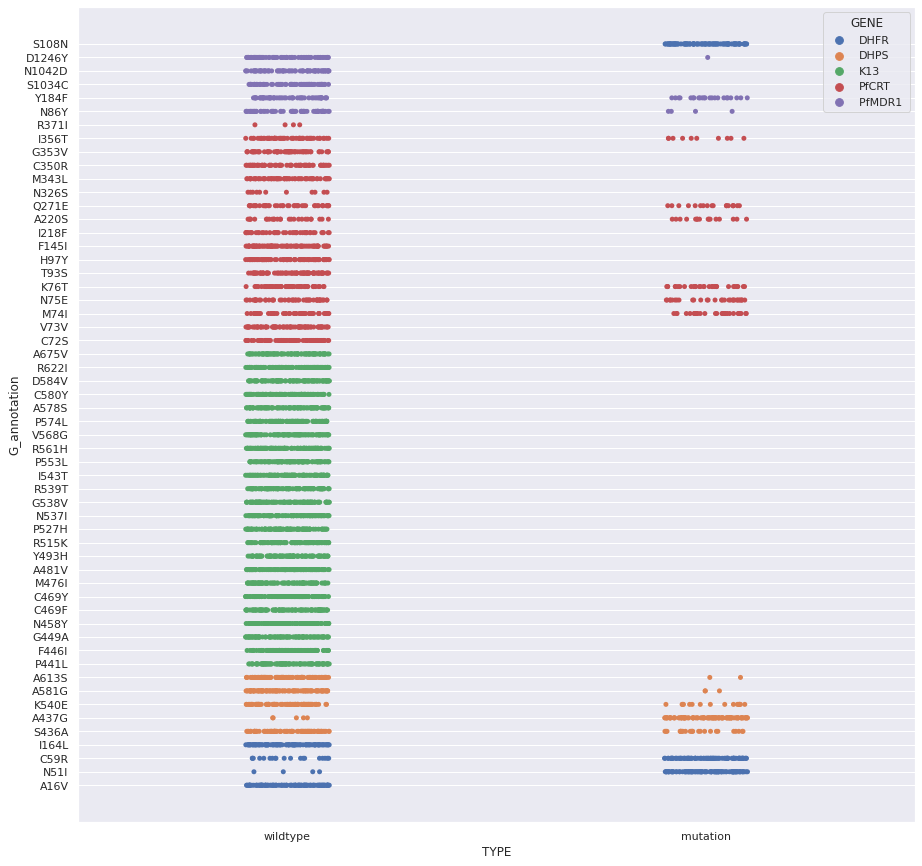

In [64]:
# Import dependencies

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Load data
df = pd.read_csv("AN19_individual_EPI.csv")


# Check dataframe is correct 
df.head()

# Print number of rows and columns; confirm its longform data
print('The number of rows, columns:', df.shape) 
print('') # add space 

# Count number of unique samples in data 
uniq = df['Sample']
print('There are', uniq.nunique(), 'samples in this dataset.')
print('') # add space 

# Check if there are any Null or NAs 

print('The number of null or NA values in data:')
print(df.isnull().sum())
print('') # add space 

# Sort data based on CODONS to ensure shown as ascending/descending in plot 

LS = df['G_annotation']  # Copy the full annotated SNPs into a new list called LS 

codon_num = [] # create an empty list 

# Loop through G_annotation list (LS) and strip first and last character 
for x in LS: 
    codon_num.append(int(x[1:-1]))  # IMPORTANTLY change from string to integer to allow num sorting 
    ## TODO: make this more pythonic and use rstrip() and lstrip().left()

# Add the new Codon column to the current dataframe 
df['Codon'] = codon_num

# Set seaborn plot style and size (NOTE: some plots will not be affected; see seaborn docs) 

#sns.set_style("whitegrid")

# Set plot/figure size 
sns.set(rc = {'figure.figsize':(15,15)})

print('Plotting all SNPs categorized as wildtype or mutant using seaborn:')

# Plot as seaborn strippplot sorting by Codon # and then Gene in ascending order 

g= sns.stripplot(data=df.sort_values(by=['GENE','Codon'], ascending=True),
               x="TYPE", y="G_annotation",
                 hue="GENE")  



# Use catplot() to combine stripplot() and FacetGrid to further categorize data; below example is by Year 

# g= sns.catplot(data=df.sort_values(by=['GENE','Codon'], ascending=True),
#                x="TYPE", y="G_annotation", 
#                hue="GENE", col="Year")  

##TODO: 
## Adjsust size for catplot, difficult to see as is. Need to look at seaborn docs. 
## Figure out why sorting is broken (might to do something with iteration of catplot() 

#Save dataframe to csv 

# df.to_csv('organized.csv')

In [65]:
import pandas as pd
dictcat={}
with open("AN19_individual_EPI.csv", "r") as r2:
    for lines in r2:
        #print(lines)
        if lines[0:2].isdigit(): #and "xx" not in lines.split(",")[0]:
            dictcat[lines[0:6]]="exist"

dict_site={}
for items in dictcat:
    dicttestind={}
    with open("AN19_individual_EPI.csv", "r") as r2:
        for lines in r2:
            if items in lines:
                dicttestind[lines.split(",")[0]]="exist"
        countindividual=0
        for item in dicttestind:
            #print(item)
            countindividual+=1
        #for item in dicttestindw:
            #if item in dicttestindm:
                #print(item)
        dict_site[items]=countindividual
        #print("individual total samples", items, countindividual)
    
    
with open ("AN19_individual_EPI.csv", "r") as t1:
    #dict_SNPs={} ###Calculate major, minor, and wildtypes by going through each line
    dict_Samples={} ##dictionary for all the samples
    dict_Genes={}
    count=0
    for lines in t1: ##Add number of major, minor, 
        #print(lines)
        count+=1
        if count>1:
            #dict_Samples[lines.split(",")[0]]="exist"
            #print(lines.split(",")[0],lines.split(",")[3],lines.split(",")[6],lines.split(",")[11].strip("\n"))
            #print(lines)
            dict_Genes[lines.split(",")[0],lines.split(",")[2],lines.split(",")[9],lines.split(",")[11].strip("\n")]="exist"#,lines.split(",")[3],lines.split(",")[6],lines.split(",")[11])

#print(dict_Genes)

dict_count={}
for items2 in dict_Genes:
    #print(items2)
    #print(items2[2] in dict_voi)
    #print(items2)
    if (items2[1],items2[2]) in dict_count:    
        dict_count[items2[1],items2[2]]=dict_count[items2[1],items2[2]]+1
    if (items2[1],items2[2]) not in dict_count:
        #print(items2)
        dict_count[items2[1],items2[2]]=1

dict_site_trans={}
for items in dict_site:
    if "Be" in items:
        dict_site_trans["Benguela"]=dict_site[items]
    if "LS" in items:
        dict_site_trans["Lunda Sul"]=dict_site[items]
    if "Za" in items:
        dict_site_trans["Zaire"]=dict_site[items]

#print(dict_site_trans)   
count=0
for items in dict_count:
    #print(items)
    #print(dict_site_trans[items[0]])
    if dict_count[items]>dict_site_trans[items[0]]:
        count+=1
print("There were", count,"samples that are over total individauls by site")
    #print(items, dict_count[items])
            
df=pd.DataFrame.from_dict(dict_count, orient='index')
df.to_csv("categorical_test1.csv", sep='\t')
            
        


There were 0 samples that are over total individauls by site


In [66]:
with open ("AN19_pooled_LAB.csv", "r") as t1: ###Open the document created from dataframe workflow
    dict_SNPs={} ###Calculate major, minor, and wildtypes by going through each line
    for lines in t1: ##Add number of major, minor, 
        currentVAF=0 ##These are sum for individaul and pools with all SNP annotation
        #print(lines)
        if "Sequence Name" not in lines: 
            #print(lines)
            if "->" in lines.split(",")[7]: ###Check if there are arrows and change of VAF due to difference of reads
                currentVAF=float(lines.split(",")[7].split(" ")[0].strip("%")) ###Assign the left side of the VAF when there is arrow
            else:
                currentVAF=float(lines.split(",")[7].strip("%")) ###If there is no arrow just strip percentage and assign VAF
            #print(currentVAF)
            if currentVAF >=50 and "individual" in lines and "21" not in lines: ##If VAF is larger or same as 10 then VAF is assigned as major
                #print(lines.split(","))
                if (lines.split(",")[1],"Major",lines.split(",")[9]) not in dict_SNPs:
                    dict_SNPs[lines.split(",")[1],"Major",lines.split(",")[9]]=1.0
                if (lines.split(",")[1],"Major",lines.split(",")[9]) in dict_SNPs:
                    dict_SNPs[lines.split(",")[1],"Major",lines.split(",")[9]]=dict_SNPs[lines.split(",")[1],"Major",lines.split(",")[9]]+1.0
            if 0<currentVAF<50 and "individual" in lines and "21" not in lines: ###If VAF is smaller than 10 but larger than 0 than VAF is assigned as minor
                if (lines.split(",")[1],"Minor",lines.split(",")[9]) not in dict_SNPs:
                    dict_SNPs[lines.split(",")[1],"Minor",lines.split(",")[9]]=1.0
                if (lines.split(",")[1],"Minor",lines.split(",")[9]) in dict_SNPs:
                    dict_SNPs[lines.split(",")[1],"Minor",lines.split(",")[9]]=dict_SNPs[lines.split(",")[1],"Minor",lines.split(",")[9]]+1.0
            if currentVAF ==0 and "individual" in lines and "21" not in lines: ## If VAF is 0 then it is assigned as wildtype
                if (lines.split(",")[1],"Wildtype",lines.split(",")[9]) not in dict_SNPs:
                    dict_SNPs[lines.split(",")[1],"Wildtype",lines.split(",")[9]]=1.0
                if (lines.split(",")[1],"Wildtype",lines.split(",")[9]) in dict_SNPs:
                    dict_SNPs[lines.split(",")[1],"Wildtype",lines.split(",")[9]]=dict_SNPs[lines.split(",")[1],"Wildtype",lines.split(",")[9]]+1.0
            if currentVAF >=50 and "pooled" in lines and "21" not in lines: ##If VAF is larger or same as 10 then VAF is assigned as major
                #print(lines.split(","))
                if (lines.split(",")[1],"Major",lines.split(",")[9]) not in dict_SNPs:
                    dict_SNPs[lines.split(",")[1],"Major",lines.split(",")[9]]=float(lines.split(",")[-2])
                if (lines.split(",")[1],"Major",lines.split(",")[9]) in dict_SNPs:
                    dict_SNPs[lines.split(",")[1],"Major",lines.split(",")[9]]=dict_SNPs[lines.split(",")[1],"Major",lines.split(",")[9]]+float(lines.split(",")[-2])
            if 0<currentVAF<50 and "pooled" in lines and "21" not in lines: ###If VAF is smaller than 10 but larger than 0 than VAF is assigned as minor
                if (lines.split(",")[1],"Minor",lines.split(",")[9]) not in dict_SNPs:
                    dict_SNPs[lines.split(",")[1],"Minor",lines.split(",")[9]]=float(lines.split(",")[-2])
                if (lines.split(",")[1],"Minor",lines.split(",")[9]) in dict_SNPs:
                    dict_SNPs[lines.split(",")[1],"Minor",lines.split(",")[9]]=dict_SNPs[lines.split(",")[1],"Minor",lines.split(",")[9]]+float(lines.split(",")[-2])
            if currentVAF ==0 and "pooled" in lines and "21" not in lines: ## If VAF is 0 then it is assigned as wildtype
                if (lines.split(",")[1],"Wildtype",lines.split(",")[9]) not in dict_SNPs:
                    dict_SNPs[lines.split(",")[1],"Wildtype",lines.split(",")[9]]=float(lines.split(",")[-2])
                if (lines.split(",")[1],"Wildtype",lines.split(",")[9]) in dict_SNPs:
                    dict_SNPs[lines.split(",")[1],"Wildtype",lines.split(",")[9]]=dict_SNPs[lines.split(",")[1],"Wildtype",lines.split(",")[9]]+float(lines.split(",")[-2])


with open ("AN19_pooled_LAB.csv", "r") as t1: ###Open the document created from dataframe workflow
    dict_SNPs_minus={} ###Calculate major, minor, and wildtypes by going through each line
    for lines in t1: ##Add number of major, minor, 
        currentVAF=0 ##These are sum for individaul and pools with all SNP annotation
        #print(lines)
        if "Sequence Name" not in lines: 
            if "->" in lines.split(",")[7]: ###Check if there are arrows and change of VAF due to difference of reads
                currentVAF=float(lines.split(",")[7].split(" ")[0].strip("%")) ###Assign the left side of the VAF when there is arrow
            else:
                currentVAF=float(lines.split(",")[7].strip("%")) ###If there is no arrow just strip percentage and assign VAF
            if currentVAF >=50 and "individual" in lines and "21" not in lines: ##If VAF is larger or same as 10 then VAF is assigned as major
                #print(lines.split(","))
                if (lines.split(",")[1],"Major",lines.split(",")[9][0:-1]) not in dict_SNPs_minus:
                    dict_SNPs_minus[lines.split(",")[1],"Major",lines.split(",")[9][0:-1]]=1.0
                if (lines.split(",")[1],"Major",lines.split(",")[9][0:-1]) in dict_SNPs_minus:
                    dict_SNPs_minus[lines.split(",")[1],"Major",lines.split(",")[9][0:-1]]=dict_SNPs_minus[lines.split(",")[1],"Major",lines.split(",")[9][0:-1]]+1.0
            if 0<currentVAF<50 and "individual" in lines and "21" not in lines: ###If VAF is smaller than 10 but larger than 0 than VAF is assigned as minor
                if (lines.split(",")[1],"Minor",lines.split(",")[9][0:-1]) not in dict_SNPs_minus:
                    dict_SNPs_minus[lines.split(",")[1],"Minor",lines.split(",")[9][0:-1]]=1.0
                if (lines.split(",")[1],"Minor",lines.split(",")[9][0:-1]) in dict_SNPs_minus:
                    dict_SNPs_minus[lines.split(",")[1],"Minor",lines.split(",")[9][0:-1]]=dict_SNPs_minus[lines.split(",")[1],"Minor",lines.split(",")[9][0:-1]]+1.0
            if currentVAF ==0 and "individual" in lines and "21" not in lines: ## If VAF is 0 then it is assigned as wildtype
                if (lines.split(",")[1],"Wildtype",lines.split(",")[9][0:-1]) not in dict_SNPs_minus:
                    dict_SNPs_minus[lines.split(",")[1],"Wildtype",lines.split(",")[9][0:-1]]=1.0
                if (lines.split(",")[1],"Wildtype",lines.split(",")[9][0:-1]) in dict_SNPs_minus:
                    dict_SNPs_minus[lines.split(",")[1],"Wildtype",lines.split(",")[9][0:-1]]=dict_SNPs_minus[lines.split(",")[1],"Wildtype",lines.split(",")[9][0:-1]]+1.0
            if currentVAF >=50 and "pooled" in lines and "21" not in lines: ##If VAF is larger or same as 10 then VAF is assigned as major
                #print(lines.split(","))
                if (lines.split(",")[1],"Major",lines.split(",")[9][0:-1]) not in dict_SNPs_minus:
                    dict_SNPs_minus[lines.split(",")[1],"Major",lines.split(",")[9][0:-1]]=float(lines.split(",")[-2])
                if (lines.split(",")[1],"Major",lines.split(",")[9][0:-1]) in dict_SNPs_minus:
                    dict_SNPs_minus[lines.split(",")[1],"Major",lines.split(",")[9][0:-1]]=dict_SNPs_minus[lines.split(",")[1],"Major",lines.split(",")[9][0:-1]]+float(lines.split(",")[-2])
            if 0<currentVAF<50 and "pooled" in lines and "21" not in lines: ###If VAF is smaller than 10 but larger than 0 than VAF is assigned as minor
                if (lines.split(",")[1],"Minor",lines.split(",")[9][0:-1]) not in dict_SNPs_minus:
                    dict_SNPs_minus[lines.split(",")[1],"Minor",lines.split(",")[9][0:-1]]=float(lines.split(",")[-2])
                if (lines.split(",")[1],"Minor",lines.split(",")[9][0:-1]) in dict_SNPs_minus:
                    dict_SNPs_minus[lines.split(",")[1],"Minor",lines.split(",")[9][0:-1]]=dict_SNPs_minus[lines.split(",")[1],"Minor",lines.split(",")[9][0:-1]]+float(lines.split(",")[-2])
            if currentVAF ==0 and "pooled" in lines and "21" not in lines: ## If VAF is 0 then it is assigned as wildtype
                if (lines.split(",")[1],"Wildtype",lines.split(",")[9][0:-1]) not in dict_SNPs_minus:
                    dict_SNPs_minus[lines.split(",")[1],"Wildtype",lines.split(",")[9][0:-1]]=float(lines.split(",")[-2])
                if (lines.split(",")[1],"Wildtype",lines.split(",")[9][0:-1]) in dict_SNPs_minus:
                    dict_SNPs_minus[lines.split(",")[1],"Wildtype",lines.split(",")[9][0:-1]]=dict_SNPs_minus[lines.split(",")[1],"Wildtype",lines.split(",")[9][0:-1]]+float(lines.split(",")[-2])
#print(dict_SNPs)
dict_SNPs_SUM={} ###Find sum of major, minor, wildtypes, total  samples

dict_SNPs_2={} ##The purpose of adding wildtype to second mutations
for items in dict_SNPs:
    #print(items)
    if (items[0], "Wildtype", items[2]) not in dict_SNPs: ##Check if wildtype is not in the dictionary 
        if (items[0],"Wildtype",items[2][0:-1]) in dict_SNPs_minus:
            dict_SNPs_2[items[0], "Wildtype", items[2]]=dict_SNPs_minus[items[0],"Wildtype",items[2][0:-1]] ###Assign wildtype to the SNP change without wildtype information

#print(dict_SNPs_2)
for items in dict_SNPs_2: ##Add back to the original dictionary
    #print(items)
    dict_SNPs[items]=dict_SNPs_2[items]

for items in dict_SNPs: ##Create a beginng value of dictionary to later add up to total
    dict_SNPs_SUM[items[0],items[2]]=0
    
###Figure out why sum  is weird for seaborn table why is it differet from WVAF total calculation so much?

#dict_count={} ## dictionary for couting how many times dict_SNP_minus which is without last letter of G_Annotation is added.
for items in dict_SNPs: ##First check if the item is in dictionary otherwise change the value of dict_count
    #print(items)
    dict_SNPs_SUM[items[0],items[2]]=dict_SNPs_SUM[items[0],items[2]]+dict_SNPs[items]

#print(dict_SNPs_SUM)        
dict_SNPS_ratio_sum = {} ##Find the ratio of major, minor, wildtypes in total samples

for items in dict_SNPs:
    #print(items)
    dict_SNPS_ratio_sum[items[1],items[2]]=0

for items in dict_SNPs:
    #print(items)
    dict_SNPS_ratio_sum[items[1],items[2]]=dict_SNPS_ratio_sum[items[1],items[2]]+round(dict_SNPs[items]/dict_SNPs_SUM[items[0],items[2]],1)

#print(dict_SNPS_ratio_sum)
dict_SNPs_final = {} ##Create final form for the SNPs
for items in dict_SNPs:
    #print(items)
    if (items[0],items[2]) not in dict_SNPs_final:
        dict_SNPs_final[items[0],items[2]]=[0,0,0,0]
    if items[1]=="Wildtype":
        dict_SNPs_final[items[0],items[2]][0]=dict_SNPS_ratio_sum[items[1],items[2]]
    if items[1]=="Major":
        dict_SNPs_final[items[0],items[2]][1]=dict_SNPS_ratio_sum[items[1],items[2]]
    if items[1]=="Minor":
        dict_SNPs_final[items[0],items[2]][2]=dict_SNPS_ratio_sum[items[1],items[2]]
    dict_SNPs_final[items[0],items[2]][3]=dict_SNPs_SUM[items[0],items[2]]

#for items in dict_SNPs_final:
    #print(dict_SNPs_final[items])
with open ("Tab_Table_SNP_Total1.csv", "w") as t2:
    t2.write("Gene+SNP,Wildtype: AF=0%,Minor: AF < 50%,Major: AF >= 50%,Samplesize\n")
    for items in dict_SNPs_final:
        if items[0]=="DHPS_437Corrected ":
            t2.write("DHPS"+":"+items[1]+","+str(dict_SNPs_final[items][0])+","+str(dict_SNPs_final[items][1])+","+str(dict_SNPs_final[items][2])+","+"N="+str(dict_SNPs_final[items][3])+"\n")
        if items[0]=="mitochondrial genome - CYTB CDS":
            t2.write("CYTB"+":"+items[1]+","+str(dict_SNPs_final[items][0])+","+str(dict_SNPs_final[items][1])+","+str(dict_SNPs_final[items][2])+","+"N="+str(dict_SNPs_final[items][3])+"\n")         
        if items[0]!= "DHPS_437Corrected " and items[0]!="mitochondrial genome - CYTB CDS":
            t2.write(items[0]+":"+items[1]+","+str(dict_SNPs_final[items][0])+","+str(dict_SNPs_final[items][1])+","+str(dict_SNPs_final[items][2])+","+"N="+str(dict_SNPs_final[items][3])+"\n")
    



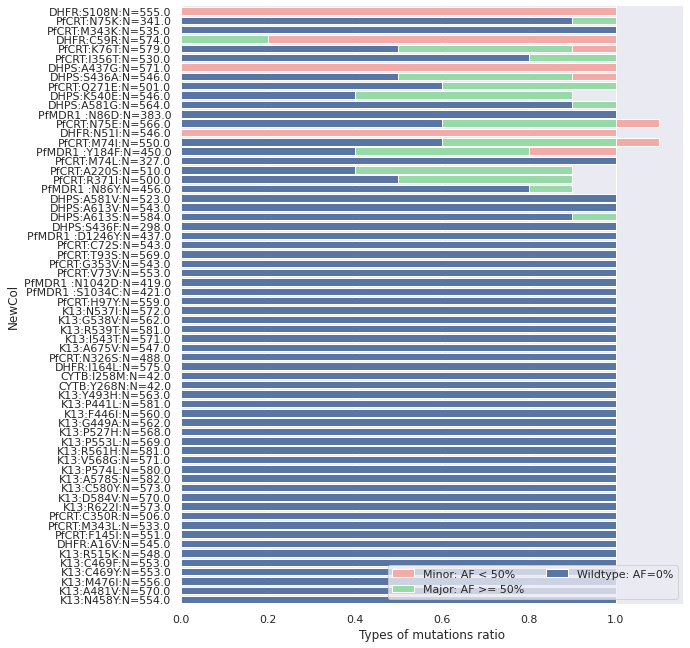

In [67]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
df_table_SNP=pd.read_csv("Tab_Table_SNP_Total1.csv")
df_table_SNP["NewCol"]=df_table_SNP["Gene+SNP"]+":"+df_table_SNP["Samplesize"]
df_table_SNP["total"]=df_table_SNP["Minor: AF < 50%"]+df_table_SNP["Major: AF >= 50%"]+df_table_SNP["Wildtype: AF=0%"]
df_table_SNP["total2"]=df_table_SNP["Major: AF >= 50%"]+df_table_SNP["Wildtype: AF=0%"]
f, ax = plt.subplots(figsize = (9,11))
sns.set_color_codes('pastel')
ax = sns.barplot(x="total", y="NewCol", label = "Minor: AF < 50%", data=df_table_SNP, color = 'r', edgecolor = 'w')
ax = sns.barplot(x="total2", y="NewCol", label= "Major: AF >= 50%", data=df_table_SNP, color = 'g', edgecolor = 'w')
sns.set_color_codes('deep')
ax = sns.barplot(x="Wildtype: AF=0%", y="NewCol", label= "Wildtype: AF=0%", data=df_table_SNP, color = 'b', edgecolor = 'w')
ax.legend(ncol = 2, loc = 'lower right')
sns.despine(left = True, bottom = True)
ax.set(xlabel="Types of mutations ratio")

#ax2 = ax.twinx()
#ax2.set_yticklabels(df_table_SNP.Samplesize)
#sns.lineplot(x="total", y='Samplesize', data=df_table_SNP, color='white', ax=ax2)
#print(df_table_SNP.Samplesize.tolist())
#ax2.set_yticklabels(df_table_SNP.Samplesize)
#list1=[]
#for x in range(0,len(df_table_SNP.GeneSNP.tolist())):
#    list1+=[x*1.1+0.1]
#ax2.set_yticks(list1)
# Set the right y-tick labels
#ax2.set_yticklabels(df_table_SNP.Samplesize.tolist())
plt.show()
